Name: Weixuan (Ariel) Shao

Station: BREMERTON, WA US

## Data Cleaning and Preprocessing

### 1. Initial Data Inspection:

<ipython-input-1-adb5f026981b>:7: DtypeWarning: Columns (3,21,27,29,30,31,32,33,37,38,43,44,57,96) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Number of duplicate timestamps before dropping: 12
Dataset Shape: (68771, 12)

Data Types:
 DATE                         datetime64[ns]
HourlyPrecipitation                 float64
HourlyDryBulbTemperature            float64
HourlyDewPointTemperature           float64
HourlyRelativeHumidity              float64
HourlySeaLevelPressure              float64
HourlyStationPressure               float64
HourlyWindSpeed                     float64
HourlyWindDirection                 float64
HourlyWindGustSpeed                 float64
HourlyWetBulbTemperature            float64
HourlyAltimeterSetting              float64
dtype: object

Missing Values:
 DATE                             0
HourlyPrecipitation           5644
HourlyDryBulbTemperature      2431
HourlyDewPointTemperature     2455
HourlyRelativeHumidity        2455
HourlySeaLevelPressure       27382
HourlyStationPressure         6043
HourlyWindSpeed               2180
HourlyWindDirection           4646
HourlyWindGustSpeed          6352

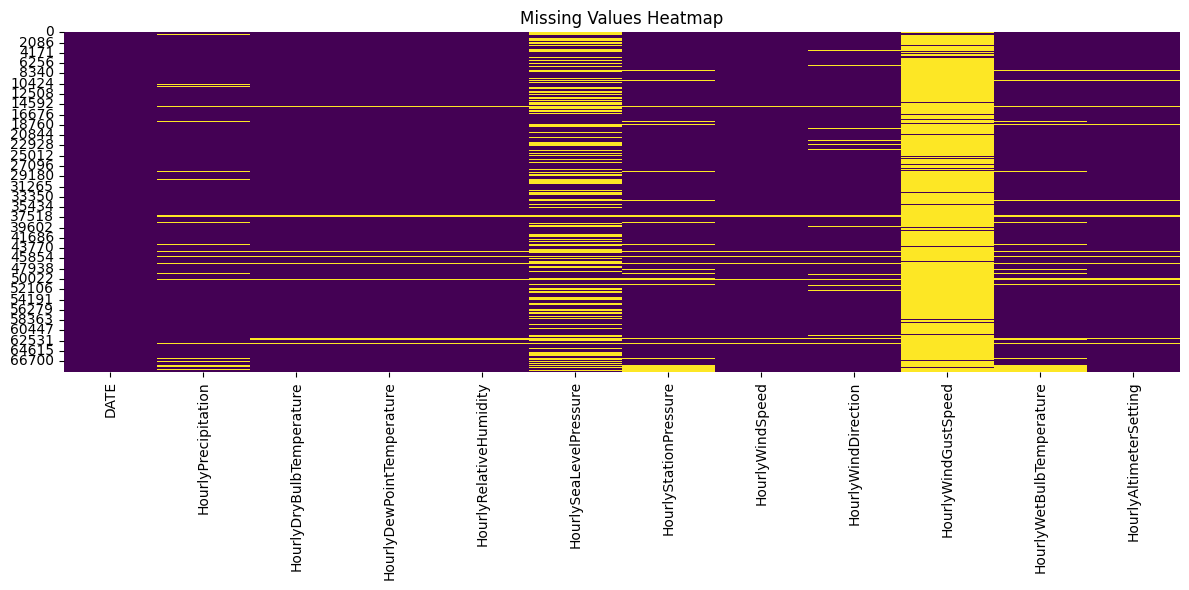

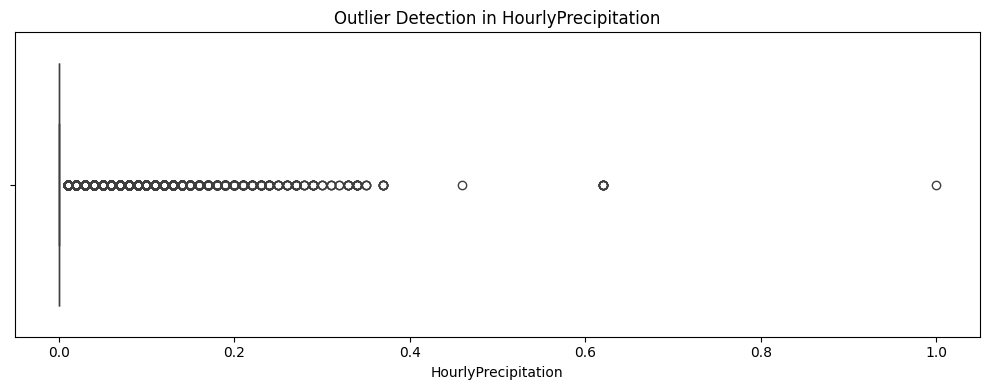

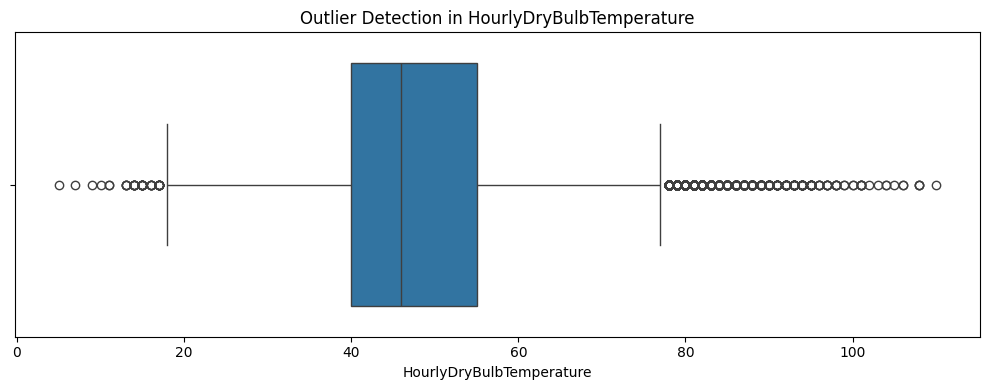

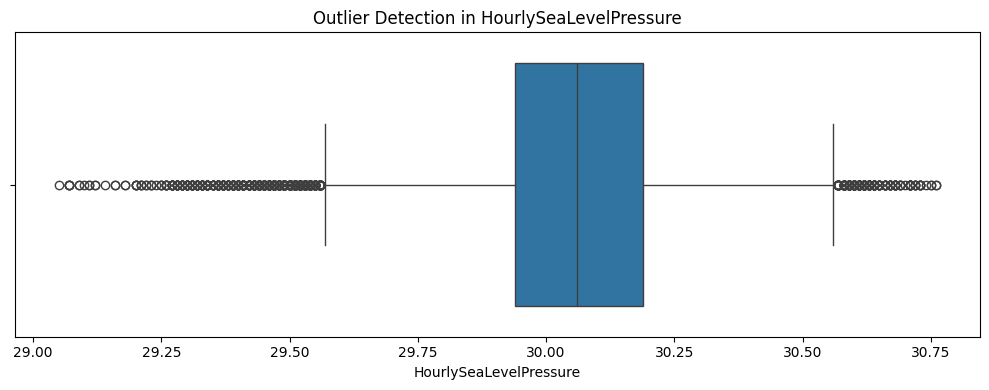

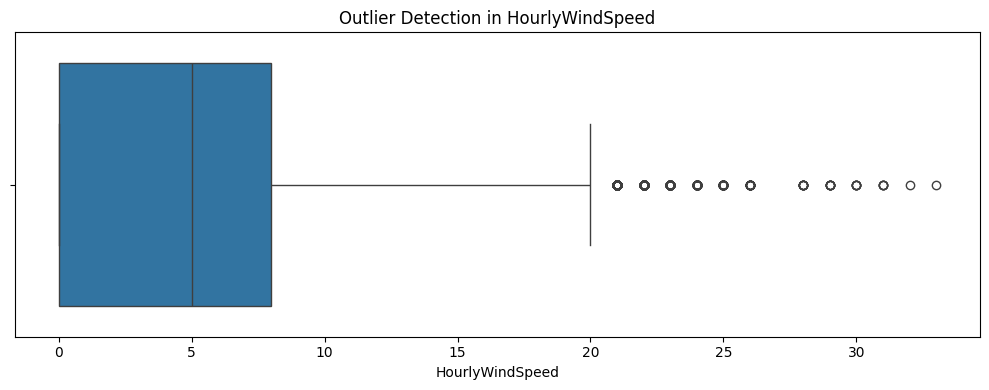

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and filter dataset
file_path = '/content/3984959.csv'
df = pd.read_csv(file_path)

# Keep only relevant columns
selected_columns = [
    'DATE',
    'HourlyPrecipitation',
    'HourlyDryBulbTemperature',
    'HourlyDewPointTemperature',
    'HourlyRelativeHumidity',
    'HourlySeaLevelPressure',
    'HourlyStationPressure',
    'HourlyWindSpeed',
    'HourlyWindDirection',
    'HourlyWindGustSpeed',
    'HourlyWetBulbTemperature',
    'HourlyAltimeterSetting'
]
df = df[selected_columns].copy()

# Check duplicate timestamps
duplicate_count = df['DATE'].duplicated().sum()
print(f"Number of duplicate timestamps before dropping: {duplicate_count}")

# Drop duplicate timestamps
df = df.drop_duplicates(subset='DATE')

# Convert all relevant columns to numeric (coerce errors)
for col in df.columns:
    if col != 'DATE':
        df[col] = (
            df[col]
            .astype(str)
            .str.replace('T', '0', case=False)
            .str.replace('Trace', '0', case=False)
            .str.replace(' ', '')
            .str.replace('<', '')
        )
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert DATE to datetime
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')

# ---- Initial Inspection ----
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)

# Check for missing values
print("\nMissing Values:\n", df.isna().sum())

# Check for duplicate timestamps
duplicate_timestamps = df['DATE'].duplicated().sum()
print(f"\nNumber of duplicate timestamps: {duplicate_timestamps}")

# Summary statistics
print("\nSummary Statistics:\n", df.describe())

# Visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.tight_layout()
plt.show()

# Check for outliers in key numeric variables
key_vars = [
    'HourlyPrecipitation',
    'HourlyDryBulbTemperature',
    'HourlySeaLevelPressure',
    'HourlyWindSpeed'
]

for var in key_vars:
    if var in df.columns:
        plt.figure(figsize=(10, 4))
        sns.boxplot(x=df[var])
        plt.title(f"Outlier Detection in {var}")
        plt.tight_layout()
        plt.show()

## 2. Handling Missing Values:

In [ ]:
# Make a copy before imputing
df_clean = df.copy().reset_index(drop=True)

# Drop HourlyWindGustSpeed (too many missing values)
df_clean.drop(columns=['HourlyWindGustSpeed'], inplace=True)

# Fill missing precipitation only if the hour before and after are both 0
precip = 'HourlyPrecipitation'
for i in df_clean[df_clean[precip].isna()].index:
    if (
        i > 0 and i < len(df_clean) - 1 and
        df_clean.iloc[i - 1][precip] == 0 and
        df_clean.iloc[i + 1][precip] == 0
    ):
        df_clean.at[i, precip] = 0

# --- Temperature, Humidity, Pressure: Interpolate (short gaps) ---
interpolate_cols = [
    'HourlyDryBulbTemperature', 'HourlyDewPointTemperature',
    'HourlyRelativeHumidity', 'HourlySeaLevelPressure',
    'HourlyStationPressure', 'HourlyWetBulbTemperature',
    'HourlyAltimeterSetting'
]
df_clean[interpolate_cols] = df_clean[interpolate_cols].interpolate(method='linear', limit=2, limit_direction='both')

# --- Wind Speed: Interpolate ---
df_clean['HourlyWindSpeed'] = df_clean['HourlyWindSpeed'].interpolate(method='linear', limit=2, limit_direction='both')

# --- Wind Direction: Forward fill ---
df_clean['HourlyWindDirection'] = df_clean['HourlyWindDirection'].ffill(limit=2)

# --- Create missingness indicator columns ---
for col in df_clean.columns:
    if col != 'DATE' and df_clean[col].isna().sum() > 0:
        df_clean[f'{col}_missing'] = df_clean[col].isna().astype(int)

# --- Drop rows with missing values in critical variables only ---
critical_cols = [
    'HourlyDryBulbTemperature',
    'HourlyDewPointTemperature',
    'HourlyRelativeHumidity',
    'HourlySeaLevelPressure',
    'HourlyStationPressure',
    'HourlyWindSpeed',
    'HourlyPrecipitation'
]
df_clean.dropna(subset=critical_cols, inplace=True)

# Final check
print("Final shape after imputation:", df_clean.shape)
print("Remaining missing values:\n", df_clean.isna().sum())

Final shape after imputation: (61413, 21)
Remaining missing values:
 DATE                                   0
HourlyPrecipitation                    0
HourlyDryBulbTemperature               0
HourlyDewPointTemperature              0
HourlyRelativeHumidity                 0
HourlySeaLevelPressure                 0
HourlyStationPressure                  0
HourlyWindSpeed                        0
HourlyWindDirection                  139
HourlyWetBulbTemperature               0
HourlyAltimeterSetting                 0
HourlyPrecipitation_missing            0
HourlyDryBulbTemperature_missing       0
HourlyDewPointTemperature_missing      0
HourlyRelativeHumidity_missing         0
HourlySeaLevelPressure_missing         0
HourlyStationPressure_missing          0
HourlyWindSpeed_missing                0
HourlyWindDirection_missing            0
HourlyWetBulbTemperature_missing       0
HourlyAltimeterSetting_missing         0
dtype: int64


## 3. Timeline Construction:

In [ ]:
# Create complete hourly timeline
start_time = df_clean['DATE'].min()
end_time = df_clean['DATE'].max()
full_timeline = pd.DataFrame({'DATE': pd.date_range(start=start_time, end=end_time, freq='H')})

# Merge your cleaned data onto the full timeline
df_full = pd.merge(full_timeline, df_clean, on='DATE', how='left')

# Check if any hours are missing after merge
missing_rows = df_full.isna().any(axis=1).sum()
print(f"Rows with at least one missing value after timeline merge: {missing_rows}")
print("Final timeline shape:", df_full.shape)

# Create a binary column for missing rows (useful if you want to flag them later)
df_full['was_missing'] = df_full.isna().any(axis=1).astype(int)

Rows with at least one missing value after timeline merge: 4709
Final timeline shape: (43848, 21)


<ipython-input-3-7d0eb4cfb9ba>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_timeline = pd.DataFrame({'DATE': pd.date_range(start=start_time, end=end_time, freq='H')})


## 4. Target Variable Creation:

In [ ]:
import numpy as np

# Step 1: Compute 95th percentile of non-zero precipitation
precip_values = df_full['HourlyPrecipitation'].dropna()
precip_nonzero = precip_values[precip_values > 0]
rain_threshold = np.percentile(precip_nonzero, 95)
print(f"95th percentile threshold for heavy rain: {rain_threshold:.2f} mm")

# Step 2: Create binary column for heavy rain in current hour
df_full['heavy_rain'] = (df_full['HourlyPrecipitation'] >= rain_threshold).astype(int)

# Step 3: Look ahead 3 hours → rolling max of future 3 hours
df_full['heavy_rain_next_3hr'] = (
    (df_full['heavy_rain'].shift(-1).fillna(0) > 0) |
    (df_full['heavy_rain'].shift(-2).fillna(0) > 0) |
    (df_full['heavy_rain'].shift(-3).fillna(0) > 0)
).astype(int)

# Step 4: Check balance of target classes
print("\nTarget value counts:")
print(df_full['heavy_rain_next_3hr'].value_counts())

df_full['heavy_rain_next_3hr'].value_counts(normalize=True)

95th percentile threshold for heavy rain: 0.15 mm

Target value counts:
heavy_rain_next_3hr
0    43352
1      496
Name: count, dtype: int64


,proportion
heavy_rain_next_3hr,
0,0.988688
1,0.011312


## 5. Data Splitting:

In [ ]:
# Step 1: Sort by time
df_full = df_full.sort_values('DATE').reset_index(drop=True)

# Step 2: Compute split indices
total_len = len(df_full)
train_end = int(0.7 * total_len)
val_end = int(0.85 * total_len)

# Step 3: Slice chronologically
df_train = df_full.iloc[:train_end]
df_val   = df_full.iloc[train_end:val_end]
df_test  = df_full.iloc[val_end:]

# Step 4: Sanity checks
print(f"Train range: {df_train['DATE'].min()} → {df_train['DATE'].max()} ({len(df_train)} rows)")
print(f"Val   range: {df_val['DATE'].min()} → {df_val['DATE'].max()} ({len(df_val)} rows)")
print(f"Test  range: {df_test['DATE'].min()} → {df_test['DATE'].max()} ({len(df_test)} rows)")

# Check target class balance
print("\nTarget balance:")
for name, subset in zip(["Train", "Validation", "Test"], [df_train, df_val, df_test]):
    print(f"{name} - Heavy rain ratio: {subset['heavy_rain_next_3hr'].mean():.4f}")

Train range: 2020-01-01 00:56:00 → 2023-07-02 20:56:00 (30693 rows)
Val   range: 2023-07-02 21:56:00 → 2024-04-01 21:56:00 (6577 rows)
Test  range: 2024-04-01 22:56:00 → 2024-12-31 23:56:00 (6578 rows)

Target balance:
Train - Heavy rain ratio: 0.0122
Validation - Heavy rain ratio: 0.0154
Test - Heavy rain ratio: 0.0032


## Feature Engineering

### Step 1: Basic Features from Raw Data

**Time Features:**

In [ ]:
# Extract basic time parts
df_full['hour'] = df_full['DATE'].dt.hour
df_full['dayofweek'] = df_full['DATE'].dt.dayofweek  # Monday=0
df_full['month'] = df_full['DATE'].dt.month
df_full['dayofyear'] = df_full['DATE'].dt.dayofyear

# Weekend indicator
df_full['is_weekend'] = df_full['dayofweek'].isin([5, 6]).astype(int)

# Sine/cosine encoding for cyclical time features
df_full['hour_sin'] = np.sin(2 * np.pi * df_full['hour'] / 24)
df_full['hour_cos'] = np.cos(2 * np.pi * df_full['hour'] / 24)

df_full['dayofyear_sin'] = np.sin(2 * np.pi * df_full['dayofyear'] / 365)
df_full['dayofyear_cos'] = np.cos(2 * np.pi * df_full['dayofyear'] / 365)

### Step 2: Derived Weather Features

**1. Atmospheric Stability Indicators:**

In [ ]:
# Dew Point Depression
df_full['dew_point_depression'] = df_full['HourlyDryBulbTemperature'] - df_full['HourlyDewPointTemperature']

# Vapor Pressure
df_full['vapor_pressure'] = 6.11 * 10 ** (7.5 * df_full['HourlyDewPointTemperature'] / (237.3 + df_full['HourlyDewPointTemperature']))

**2. Wind Components:**

In [ ]:
# Convert degrees to radians
wind_dir_rad = np.deg2rad(df_full['HourlyWindDirection'])

# Calculate u and v components
df_full['wind_u'] = df_full['HourlyWindSpeed'] * np.sin(wind_dir_rad) * -1
df_full['wind_v'] = df_full['HourlyWindSpeed'] * np.cos(wind_dir_rad) * -1

### Step 3: Historical and Trend Features

**1. Precipitation History:**

In [ ]:
# Cumulative precipitation (rolling sum)
rolling_windows = [3, 6, 12, 24]

for hours in rolling_windows:
    df_full[f'precip_sum_past_{hours}h'] = df_full['HourlyPrecipitation'].rolling(window=hours, min_periods=1).sum()

# Max precipitation (rolling max)
for hours in rolling_windows:
    df_full[f'precip_max_past_{hours}h'] = df_full['HourlyPrecipitation'].rolling(window=hours, min_periods=1).max()

# Current precipitation indicator (binary)
df_full['is_precipitating'] = (df_full['HourlyPrecipitation'] > 0).astype(int)

# Hours since last rain
df_full['hours_since_rain'] = (~(df_full['HourlyPrecipitation'] > 0)).astype(int).groupby(df_full['is_precipitating'].cumsum()).cumsum()

**2. Trend Features:**

In [ ]:
# Variables to calculate trend features for (temperature, humidity, pressure, wind speed, dew point)
trend_vars = [
    'HourlyDryBulbTemperature',
    'HourlyDewPointTemperature',
    'HourlyRelativeHumidity',
    'HourlyStationPressure',
    'HourlyWindSpeed'
]

# Time windows in hours
time_deltas = [1, 3, 6]

# Calculate trend features
for var in trend_vars:
    for delta in time_deltas:
        # Difference over time window
        df_full[f'{var}_change_{delta}h'] = df_full[var] - df_full[var].shift(delta)

        # Rate of change per hour
        df_full[f'{var}_rate_{delta}h'] = df_full[f'{var}_change_{delta}h'] / delta

### Step 4: Model-Specific Features

**1. Random Forest-Specific Features:**

In [ ]:
# High humidity indicator
df_full['high_humidity'] = (df_full['HourlyRelativeHumidity'] >= 90).astype(int)

# Rapid 3-hour pressure drop indicator
df_full['pressure_drop_3hr'] = (
    df_full['HourlySeaLevelPressure'] - df_full['HourlySeaLevelPressure'].shift(3)
)
df_full['rapid_pressure_drop'] = (df_full['pressure_drop_3hr'] <= -1.5).astype(int)

In [ ]:
# Interaction terms between related variables
df_full['humidity_temp'] = df_full['HourlyRelativeHumidity'] * df_full['HourlyDryBulbTemperature']
df_full['wind_pressure'] = df_full['HourlyWindSpeed'] * df_full['HourlySeaLevelPressure']
df_full['dewpoint_temp'] = df_full['HourlyDewPointTemperature'] * df_full['HourlyDryBulbTemperature']

**2. Autoencoder-Specific Features:**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# Select numeric columns (excluding target + datetime + lagged)
exclude_cols = ['DATE', 'heavy_rain', 'heavy_rain_next_3hr']
feature_cols = [col for col in df_full.select_dtypes(include='number').columns if col not in exclude_cols and '_lag' not in col]

# Scale the selected features using MinMaxScaler
scaler = MinMaxScaler()
df_full[feature_cols] = scaler.fit_transform(df_full[feature_cols])

# Save the fitted scaler to use later
joblib.dump(scaler, 'minmax_scaler.pkl')
joblib.dump(feature_cols, 'scaled_feature_columns.pkl')

# Create lagged features for t-1, t-2, t-3 for each feature
lags = [1, 2, 3]
lagged_features = []

for col in feature_cols:
    for lag in lags:
        lag_col = df_full[col].shift(lag).rename(f'{col}_lag{lag}')
        lagged_features.append(lag_col)

# Concatenate lagged features into one DataFrame
lagged_df = pd.concat(lagged_features, axis=1)

# Merge lagged features back into main DataFrame
df_full = pd.concat([df_full, lagged_df], axis=1)

# Drop rows with NaNs caused by shifting
df_full.dropna(inplace=True)

In [ ]:
# Re-split the updated df_full
df_full = df_full.sort_values('DATE').reset_index(drop=True)
total_len = len(df_full)
train_end = int(0.7 * total_len)
val_end = int(0.85 * total_len)

df_train = df_full.iloc[:train_end]
df_val = df_full.iloc[train_end:val_end]
df_test = df_full.iloc[val_end:]

In [ ]:
# Reload the scaler
import joblib
scaler = joblib.load('minmax_scaler.pkl')

# Load the same feature list used during training
feature_cols = joblib.load('scaled_feature_columns.pkl')

# Apply the SAME scaler to each split
df_train.loc[:, feature_cols] = scaler.transform(df_train[feature_cols])
df_val.loc[:, feature_cols] = scaler.transform(df_val[feature_cols])
df_test.loc[:, feature_cols] = scaler.transform(df_test[feature_cols])

## Model Building

### Random Forest Model Implementation

**1. Feature Selection:**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Step 1: Define input features and target
X = df_full.drop(columns=['DATE', 'heavy_rain', 'heavy_rain_next_3hr'])
y = df_full['heavy_rain_next_3hr']

# Step 2: Ensure feature names are unique
def deduplicate_columns(columns):
    seen = {}
    new_cols = []
    for col in columns:
        if col not in seen:
            seen[col] = 1
            new_cols.append(col)
        else:
            new_name = f"{col}_{seen[col]}"
            seen[col] += 1
            new_cols.append(new_name)
    return new_cols

X.columns = deduplicate_columns(X.columns)

# Step 3: Train random forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X, y)

# Step 4: Get top features
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)
print("Top features:\n", importances.head(15))

# Step 5: Filter highly correlated features (correlation threshold = 0.95)
top_features = importances.head(15).index.tolist()
corr_matrix = X[top_features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
filtered_features = [f for f in top_features if f not in to_drop]

print(f"\nFiltered features (after removing high-correlation ones):\n{filtered_features}")

Top features:
 HourlyPrecipitation                0.037516
precip_sum_past_3h                 0.029992
precip_max_past_3h                 0.019946
precip_sum_past_3h_lag1            0.015940
precip_sum_past_6h                 0.014423
HourlyPrecipitation_lag1           0.013339
precip_max_past_6h                 0.011162
precip_sum_past_12h                0.011071
precip_max_past_3h_lag1            0.010731
HourlyStationPressure_change_1h    0.010362
HourlyStationPressure_rate_3h      0.010009
HourlyStationPressure_change_3h    0.009495
HourlyStationPressure_rate_1h      0.009053
precip_sum_past_24h                0.008129
precip_max_past_6h_lag1            0.007819
dtype: float64

Filtered features (after removing high-correlation ones):
['HourlyPrecipitation', 'precip_sum_past_3h', 'precip_sum_past_3h_lag1', 'precip_sum_past_6h', 'HourlyPrecipitation_lag1', 'precip_max_past_6h', 'precip_sum_past_12h', 'HourlyStationPressure_change_1h', 'HourlyStationPressure_rate_3h', 'precip_sum_pas

In [ ]:
print(df_full.columns.tolist())

['DATE', 'HourlyPrecipitation', 'HourlyDryBulbTemperature', 'HourlyDewPointTemperature', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyWindSpeed', 'HourlyWindDirection', 'HourlyWetBulbTemperature', 'HourlyAltimeterSetting', 'HourlyPrecipitation_missing', 'HourlyDryBulbTemperature_missing', 'HourlyDewPointTemperature_missing', 'HourlyRelativeHumidity_missing', 'HourlySeaLevelPressure_missing', 'HourlyStationPressure_missing', 'HourlyWindSpeed_missing', 'HourlyWindDirection_missing', 'HourlyWetBulbTemperature_missing', 'HourlyAltimeterSetting_missing', 'was_missing', 'heavy_rain', 'heavy_rain_next_3hr', 'hour', 'dayofweek', 'month', 'dayofyear', 'is_weekend', 'hour_sin', 'hour_cos', 'dayofyear_sin', 'dayofyear_cos', 'dew_point_depression', 'vapor_pressure', 'wind_u', 'wind_v', 'precip_sum_past_3h', 'precip_sum_past_6h', 'precip_sum_past_12h', 'precip_sum_past_24h', 'precip_max_past_3h', 'precip_max_past_6h', 'precip_max_past_12h', 'precip_max_past_24

**2. Hyperparameter Tuning:**

In [ ]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV

# Define refined parameter grid based on earlier results
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [4, 5, 6],
    'min_samples_leaf': [1, 2, 3],
    'class_weight': ['balanced']
}

# Use F1 as the scoring metric
scorer = make_scorer(f1_score)

# Initialize model and GridSearchCV
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scorer,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Filter out any feature names that are not actually in the current DataFrame
filtered_features = [col for col in filtered_features if col in df_full.columns]

# Subset data using the filtered features
X = df_full[filtered_features]
y = df_full['heavy_rain_next_3hr']

# Fit grid search
grid_search.fit(X, y)

# Display best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 200}
Best F1 Score: 0.4010541431308183


**3. Model Evaluation:**

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5352
           1       0.26      0.40      0.32        93

    accuracy                           0.97      5445
   macro avg       0.63      0.69      0.65      5445
weighted avg       0.98      0.97      0.97      5445

Confusion Matrix:


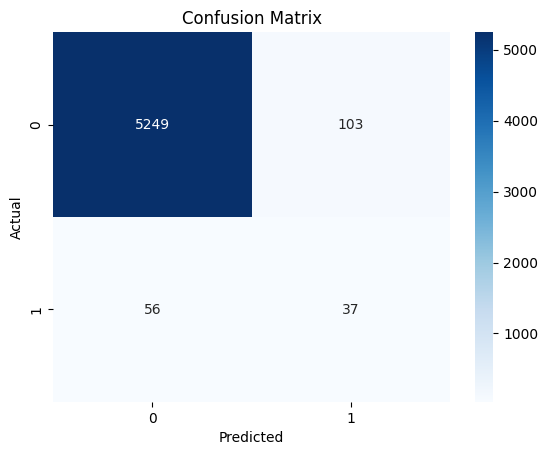

ROC AUC Score: 0.8865


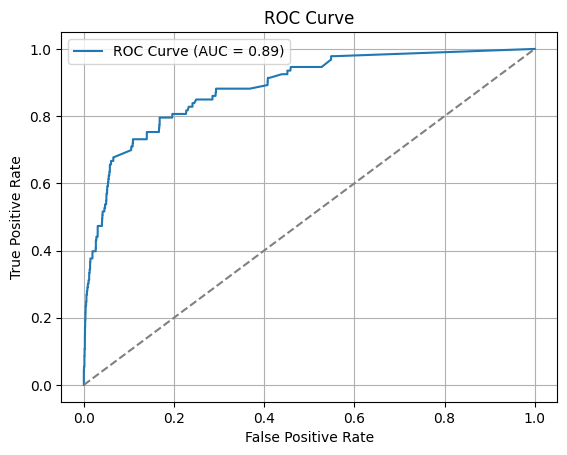

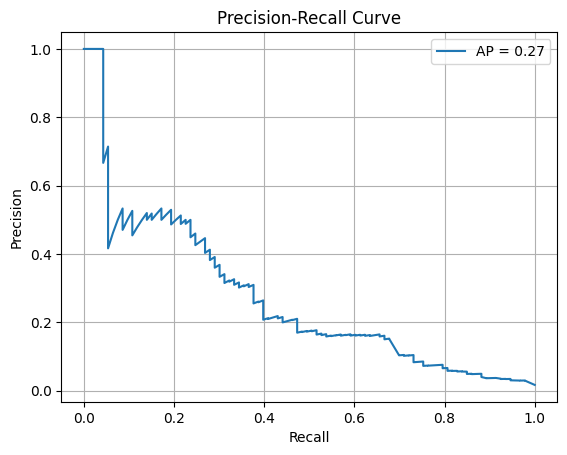

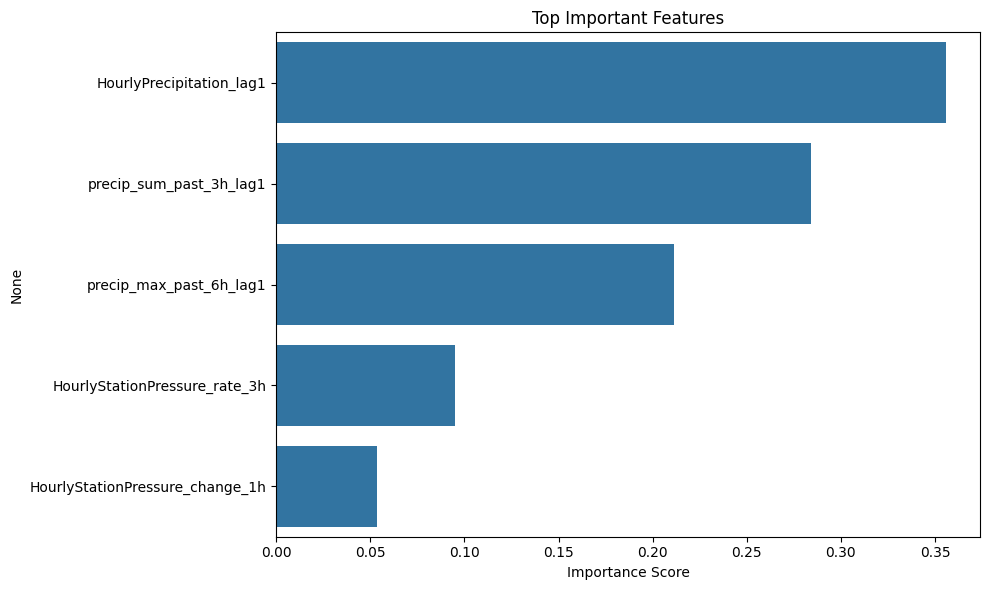

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# === STEP 1: Remove leakage features ===
leakage_features = [
    'is_precipitating', 'HourlyPrecipitation',
    'precip_sum_past_3h', 'precip_max_past_3h',
    'precip_sum_past_6h', 'precip_max_past_6h',
    'precip_sum_past_12h', 'precip_max_past_12h',
    'precip_sum_past_24h', 'precip_max_past_24h',
    'hours_since_rain'
]
filtered_features = [f for f in filtered_features if f not in leakage_features]

# === STEP 2: SMOTE ===
X_train = df_train[filtered_features]
y_train = df_train['heavy_rain_next_3hr']

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# === STEP 3: Train model ===
rf_best = RandomForestClassifier(**grid_search.best_params_, random_state=42)
rf_best.fit(X_train_resampled, y_train_resampled)

# === STEP 4: Evaluate on validation set ===
y_val = df_val['heavy_rain_next_3hr']
y_pred = rf_best.predict(df_val[filtered_features])
y_prob = rf_best.predict_proba(df_val[filtered_features])[:, 1]

print("Classification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

roc_auc = roc_auc_score(y_val, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_prob)
ap_score = average_precision_score(y_val, y_prob)
plt.plot(recall, precision, label=f"AP = {ap_score:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.legend()
plt.show()

# === STEP 5: Feature Importance ===
importances = pd.Series(rf_best.feature_importances_, index=filtered_features)

# Select top 20, remove correlated ones
top_features = importances.sort_values(ascending=False).head(20).index.tolist()
corr_matrix = X_train_resampled[top_features].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [col for col in upper.columns if any(upper[col] > 0.95)]
filtered_features = [f for f in top_features if f not in to_drop_corr]

# Plot final top features
top_importances = importances[filtered_features].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_importances.index)
plt.title("Top Important Features")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

### Autoencoder Model Implementation

**1. Data Preparation:**

In [ ]:
# Define normal data (non-heavy rainfall events)
df_normal = df_train[df_train['heavy_rain_next_3hr'] == 0]

# Select features (same as used for Random Forest after filtering)
X_normal = df_normal[filtered_features]

# Validation data contains both normal and anomaly
X_val = df_val[filtered_features]
y_val = df_val['heavy_rain_next_3hr']

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_normal_scaled = scaler.fit_transform(X_normal)
X_val_scaled = scaler.transform(X_val)

**2. Autoencoder Architecture:**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Input dimension
input_dim = X_normal_scaled.shape[1]

# === Define Autoencoder ===
# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
latent = Dense(16, activation='relu')(encoded)  # Latent space

# Decoder
decoded = Dense(32, activation='relu')(latent)
decoded = Dense(64, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

# Build model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Summary
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,973 (23.33 KB)

 Trainable params: 5,973 (23.33 KB)

 Non-trainable params: 0 (0.00 B)

**3. Model Training:**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# === Data Preparation ===
# Scale the features (MinMax since we used sigmoid activation in output)
scaler = MinMaxScaler()
X_normal_scaled = scaler.fit_transform(X_normal)  # Use only normal (non-heavy rainfall) data

# Train/Validation split
X_train_ae, X_val_ae = train_test_split(X_normal_scaled, test_size=0.2, random_state=42)

# === Callbacks ===
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# === Train Autoencoder ===
history = autoencoder.fit(
    X_train_ae, X_train_ae,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_ae, X_val_ae),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0464 - val_loss: 0.0021
Epoch 2/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0018 - val_loss: 2.8677e-04
Epoch 3/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.0638e-04 - val_loss: 2.1764e-04
Epoch 4/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2637e-04 - val_loss: 1.5600e-04
Epoch 5/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.4472e-04 - val_loss: 7.2561e-05
Epoch 6/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.3702e-05 - val_loss: 8.4072e-05
Epoch 7/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.3397e-05 - val_loss: 5.1012e-05
Epoch 8/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.8383e-05 - val_loss: 4.3495e-05
Epoch 9/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4146e-05 - val_loss: 3.6698e-05
Epoch 10/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4864e-05 - val_loss: 3.3784e-05
Epoch 11/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss:

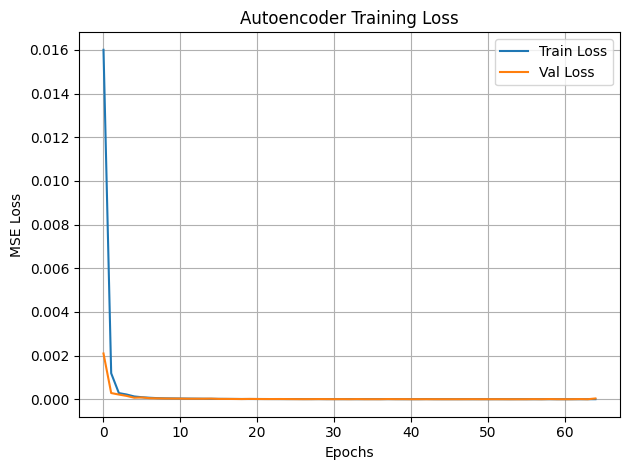

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

**4. Anomaly Detection:**

171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
628/628 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Best Threshold: 0.00001, Best F1 Score: 0.261


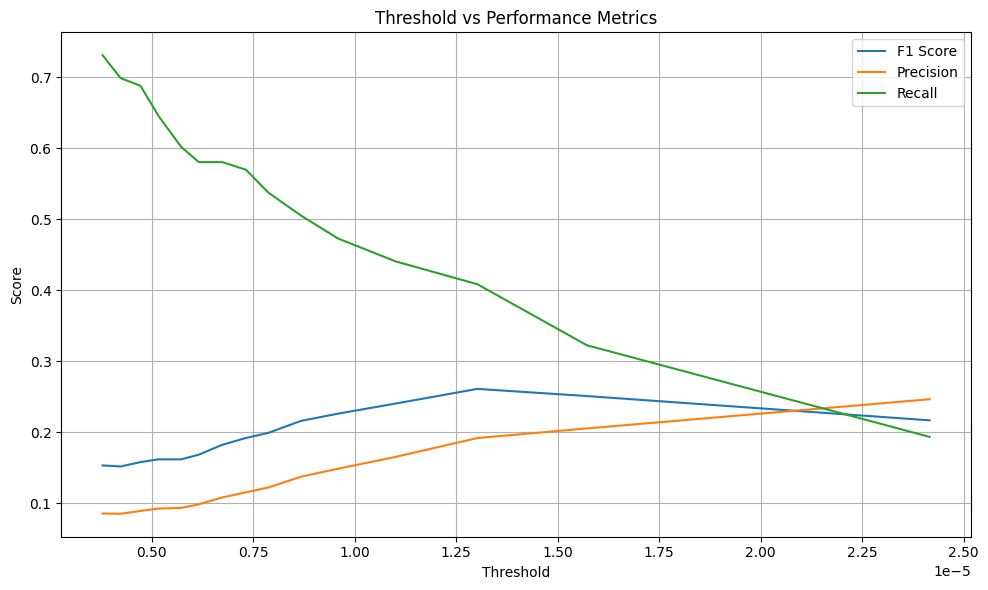

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5352
           1       0.19      0.41      0.26        93

    accuracy                           0.96      5445
   macro avg       0.59      0.69      0.62      5445
weighted avg       0.98      0.96      0.97      5445

Confusion Matrix:


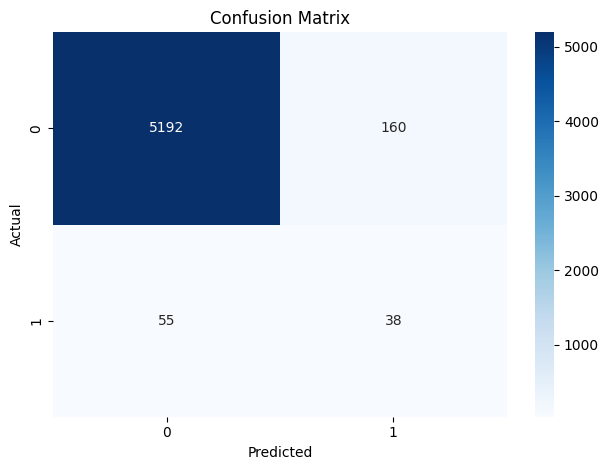

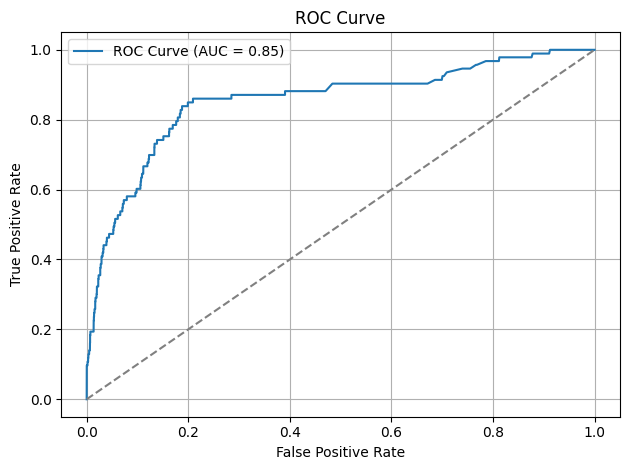

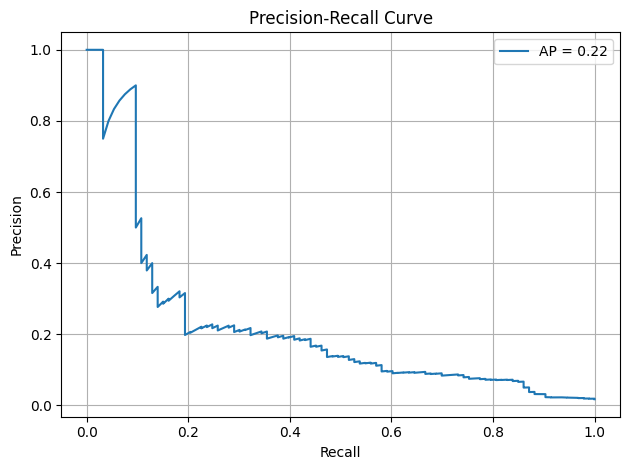

In [ ]:
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_score, recall_score, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

# === 1. Prepare validation data (normal + anomalous) ===
X_val_scaled = scaler.transform(df_val[filtered_features])
y_true = df_val['heavy_rain_next_3hr'].values  # True labels

# === 2. Reconstruct and calculate MSE ===
reconstructions = autoencoder.predict(X_val_scaled)
mse = np.mean(np.square(X_val_scaled - reconstructions), axis=1)

# === 3. Determine threshold from training reconstruction error ===
train_recon = autoencoder.predict(X_train_ae)
train_mse = np.mean(np.square(X_train_ae - train_recon), axis=1)

# === 4. Optimize threshold on validation set ===
thresholds = np.percentile(train_mse, np.arange(85, 100, 1))  # 85th to 99th
best_f1 = 0
best_thresh = 0

f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    y_pred = (mse > t).astype(int)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred)

    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"Best Threshold: {best_thresh:.5f}, Best F1 Score: {best_f1:.3f}")

# === 5. Plot F1, Precision, Recall vs Thresholds ===
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Performance Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 6. Final Prediction with Best Threshold ===
y_pred = (mse > best_thresh).astype(int)

# === 7. Evaluation ===
print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# === 8. ROC Curve ===
fpr, tpr, _ = roc_curve(y_true, mse)
roc_auc = roc_auc_score(y_true, mse)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# === 9. Precision-Recall Curve ===
precision, recall, _ = precision_recall_curve(y_true, mse)
ap_score = average_precision_score(y_true, mse)
plt.plot(recall, precision, label=f"AP = {ap_score:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Model Comparison and Analysis

**1. Performance Metrics:**

In [ ]:
# Feature Selection and Filtering
top_features = importances.sort_values(ascending=False).head(20).index.tolist()
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
filtered_features = [f for f in top_features if f not in to_drop]
filtered_features = [f for f in filtered_features if f in df_full.columns]

# Align Features and Target
df_aligned = df_full.dropna(subset=['heavy_rain_next_3hr'] + filtered_features)

X = df_aligned[filtered_features]
y = df_aligned['heavy_rain_next_3hr']

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_normal_scaled = scaler.fit_transform(X)

# Train/Test Split (Shared by Both Models)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_normal_scaled, y, test_size=0.2, random_state=42)
X_val_ae = X_val  # autoencoder uses same validation data

In [ ]:
# --- Random Forest ---
rf_pred = rf_best.predict(X_val)
rf_proba = rf_best.predict_proba(X_val)[:, 1]

# --- Autoencoder ---
ae_reconstructed = autoencoder.predict(X_val_ae)
ae_errors = np.mean(np.square(X_val_ae - ae_reconstructed), axis=1)
ae_pred = (ae_errors > best_thresh).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


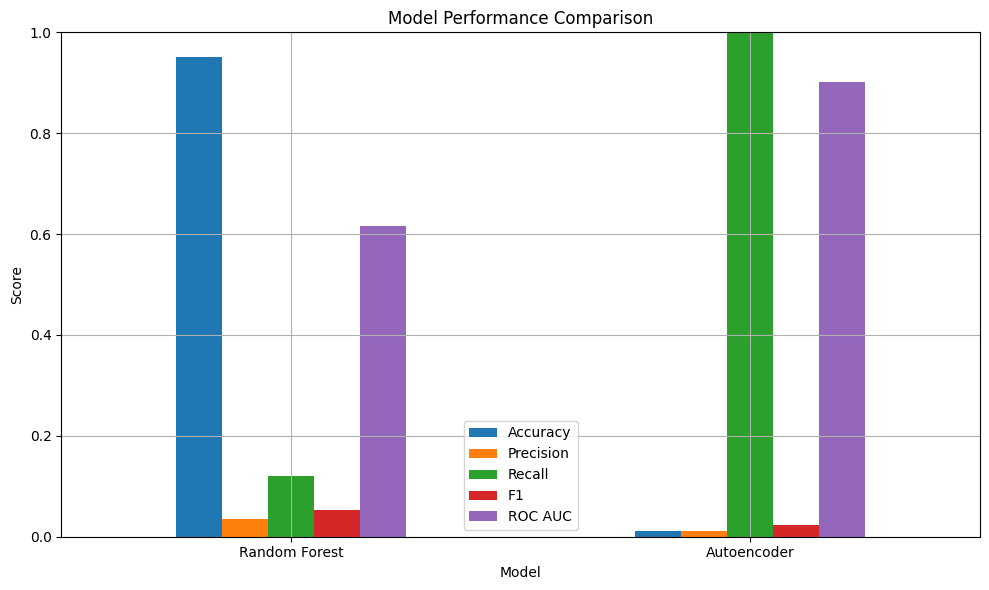

In [ ]:
# Performance Metrics
results_df = pd.DataFrame([
    {
        "Model": "Random Forest",
        "Accuracy": accuracy_score(y_val, rf_pred),
        "Precision": precision_score(y_val, rf_pred),
        "Recall": recall_score(y_val, rf_pred),
        "F1": f1_score(y_val, rf_pred),
        "ROC AUC": roc_auc_score(y_val, rf_proba)
    },
    {
        "Model": "Autoencoder",
        "Accuracy": accuracy_score(y_val, ae_pred),
        "Precision": precision_score(y_val, ae_pred),
        "Recall": recall_score(y_val, ae_pred),
        "F1": f1_score(y_val, ae_pred),
        "ROC AUC": roc_auc_score(y_val, ae_errors)
    }
])


# Plot Comparison
results_df.set_index("Model").plot(kind="bar", figsize=(10, 6), ylim=(0, 1), grid=True, rot=0)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

- Random Forest has very high Accuracy, but much lower Recall and F1, which might indicate class imbalance or that it's favoring the majority class.

- Autoencoder shows:
Recall = 1.0, which is suspiciously perfect. Also there is a low precision, accuracy, and F1, but High ROC AUC.

In [ ]:
from sklearn.metrics import classification_report

print("=== Random Forest ===")
print(classification_report(y_val, rf_pred))

print("=== Autoencoder ===")
print(classification_report(y_val, ae_pred))

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      7178
           1       0.03      0.12      0.05        83

    accuracy                           0.95      7261
   macro avg       0.51      0.54      0.51      7261
weighted avg       0.98      0.95      0.96      7261

=== Autoencoder ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7178
           1       0.01      1.00      0.02        83

    accuracy                           0.01      7261
   macro avg       0.01      0.50      0.01      7261
weighted avg       0.00      0.01      0.00      7261



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Both models were evaluated on a highly imbalanced dataset, where only 1.1% of samples belonged to the positive class (heavy_rain_next_3hr = 1). As a result, while the Random Forest model achieved high overall accuracy (95%), it struggled to identify positive cases, with a recall of only 12% and precision of 3% for the minority class. The Autoencoder performed even worse, predicting every sample as positive, resulting in perfect recall but near-zero precision and overall accuracy.

This highlights that accuracy alone is misleading in imbalanced classification tasks. Metrics such as precision, recall, and F1-score provide a more realistic assessment of performance. Future work should address class imbalance using techniques like class weighting, oversampling (e.g., SMOTE), or anomaly-focused threshold tuning to improve detection of rare but important events like heavy rainfall.